In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.applications import MobileNet, Xception, ResNet50, InceptionV3
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Google Drive 마운트

In [2]:
from google.colab import drive   

drive.mount('/content/gdrive/')  

Mounted at /content/gdrive/


In [3]:
# 파일 다운로드

import shutil

shutil.copy('/content/gdrive/My Drive/Colab Notebooks/datasets/snapshot.zip', '/content/')

'/content/snapshot.zip'

# root dir 설정 (Colab 이외의 환경에서는 root dir 을 변경해주면 된다)

In [5]:
root_dir = '/content'

In [6]:
import os
import shutil

# 작업 디렉토리는 crop_image

if os.path.exists( os.path.join(root_dir, 'crop_image/org') ):

    shutil.rmtree( os.path.join(root_dir, 'crop_image/org') )
    print(os.path.join(root_dir, 'crop_image/org') + ' is deleted !!')

In [7]:
import os
import shutil

# 작업 디렉토리는 flower_image

if os.path.exists( os.path.join(root_dir, 'crop_image/train') ):

    shutil.rmtree( os.path.join(root_dir, 'crop_image/train') )
    print(os.path.join(root_dir, 'crop_image/train') + ' is deleted !!')

In [8]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile(os.path.join(root_dir, 'snapshot.zip'), 'r') as target_file:

    # target_file.extractall(os.path.join(root_dir, 'crop_image/train')) 
    target_file.extractall(os.path.join(root_dir, 'crop_image/org')) 

In [9]:
# 데이터 전체 개수 확인

import os
import glob

# 데이터 정답 (label) 개수 및 종류 확인

# label_name_list = os.listdir(os.path.join(root_dir, 'crop_image/train/'))
label_name_list = os.listdir(os.path.join(root_dir, 'crop_image/org/'))

print('total label nums = ', len(label_name_list))
print('=================================================')
print(label_name_list)

total label nums =  4
['daikon', 'cabbage', 'carrot', 'garlic']


test 디렉토리는 ImageDataGenerator 이용해서 test 용도로 사용되며,  test_image_files 디렉토리는 정답별로 분리된 test 파일들을 그대로 복사해 놓은 디렉토리임. 목적은 전체 정확도가 아닌 random 하게 선택해서 정답과 예측 값을 직접 확인하기 위함.

validation 은 validation_split 이용해서 실행

In [10]:
import os
import shutil


if not os.path.exists(os.path.join(root_dir, 'crop_image/train')):    
    
    os.mkdir(os.path.join(root_dir, 'crop_image/train'))
    print(os.path.join(root_dir, 'crop_image/train') + ' is created !!!')

if not os.path.exists(os.path.join(root_dir, 'crop_image/test')):    
    
    os.mkdir(os.path.join(root_dir, 'crop_image/test'))
    print(os.path.join(root_dir, 'crop_image/test') + ' is created !!!')

if not os.path.exists(os.path.join(root_dir, 'crop_image/test_image_files')):    
    
    os.mkdir(os.path.join(root_dir, 'crop_image/test_image_files'))
    print(os.path.join(root_dir, 'crop_image/test_image_files') + ' is created !!!')

/content/crop_image/train is created !!!
/content/crop_image/test is created !!!
/content/crop_image/test_image_files is created !!!


파일명: 정답.숫자.jpg 로 변경


In [11]:
import os
import glob
import shutil
import random

src_root_dir = os.path.join(root_dir, 'crop_image/org/')
dst_root_dir = os.path.join(root_dir, 'crop_image/train/')


label_name_list = os.listdir(src_root_dir)

# 파일 copy src dir => dst dir

for label_name in label_name_list:

    image_file_list = glob.glob(src_root_dir+label_name+'/*')

    print('========================================================================')
    print('total [%s] image file nums => [%s]' % (label_name ,len(image_file_list)))

    copy_nums = 0

    for image_file in image_file_list:

        re_file_name = dst_root_dir + label_name + '/' + label_name + '.' + str(copy_nums) + '.jpg'
        # re_file_name = label_name + '.' + str(copy_nums) + '.jpg'

        # print('image_file => ', image_file)

        if not os.path.exists(dst_root_dir + label_name):
            os.mkdir(dst_root_dir + label_name)
            print(dst_root_dir + label_name + ' is created !!')

        shutil.copy(image_file, re_file_name)    # copy 

        copy_nums = copy_nums + 1

    print('total copy nums => ', copy_nums)
    print('========================================================================')

total [daikon] image file nums => [1000]
/content/crop_image/train/daikon is created !!
total copy nums =>  1000
total [cabbage] image file nums => [1000]
/content/crop_image/train/cabbage is created !!
total copy nums =>  1000
total [carrot] image file nums => [1000]
/content/crop_image/train/carrot is created !!
total copy nums =>  1000
total [garlic] image file nums => [600]
/content/crop_image/train/garlic is created !!
total copy nums =>  600


train 디렉토리에서 에서 test 디렉토리로 먼저 move 한후, test 디렉토리에서 test_image_files 디렉토리로는 copy

먼저 train -> test 디렉토리로 ratio 만큼 move

In [12]:
import os
import glob
import shutil
import random

# 분리 비율
ratio = 0.1    # train : test = 90 : 10

src_root_dir = os.path.join(root_dir,'crop_image/train/')
dst_root_dir = os.path.join(root_dir, 'crop_image/test/')

# train 디렉토리에 먼저 label 디렉토리 생성함

label_name_list = os.listdir(src_root_dir)

count = 0

for label_name in label_name_list:

    dst_label_name_dir = dst_root_dir + label_name

    if not os.path.exists(dst_label_name_dir):
        os.mkdir(dst_label_name_dir)
        print(dst_label_name_dir + ' is created !!')
        count = count + 1

print(len(label_name_list), count)

# 파일 move src dir => dst dir

for label_name in label_name_list:

    train_image_file_list = glob.glob(src_root_dir+label_name+'/*')

    print('========================================================================')
    print('total [%s] image file nums => [%s]' % (label_name ,len(train_image_file_list)))

    # data shuffle
    split_num = int(ratio*len(train_image_file_list))

    print('split nums => ', split_num)

    # extract test data from train data
    test_image_file_list = train_image_file_list[0:split_num]

    move_nums = 0

    for image_file in test_image_file_list:

        shutil.move(image_file, dst_root_dir+label_name)    # move 

        move_nums = move_nums + 1

    print('total move nums => ', move_nums)
    print('========================================================================')

/content/crop_image/test/daikon is created !!
/content/crop_image/test/cabbage is created !!
/content/crop_image/test/carrot is created !!
/content/crop_image/test/garlic is created !!
4 4
total [daikon] image file nums => [1000]
split nums =>  100
total move nums =>  100
total [cabbage] image file nums => [1000]
split nums =>  100
total move nums =>  100
total [carrot] image file nums => [1000]
split nums =>  100
total move nums =>  100
total [garlic] image file nums => [600]
split nums =>  60
total move nums =>  60


In [13]:
# train : test 데이터 비율 확인

src_root_dir = os.path.join(root_dir,'crop_image/train/')
dst_root_dir = os.path.join(root_dir, 'crop_image/test/')

train_label_name_list = os.listdir(src_root_dir)
test_label_name_list = os.listdir(src_root_dir)

train_label_name_list.sort()
test_label_name_list.sort()

if train_label_name_list != test_label_name_list:
    print('fatal error !!!!')
else:
    print(len(train_label_name_list), len(test_label_name_list))

# 데이터 개수 확인

for label_name in train_label_name_list:

    train_data_nums = len(os.listdir(src_root_dir+label_name))
    test_data_nums = len(os.listdir(dst_root_dir+label_name))

    print('train => ', label_name, train_data_nums, ' , test => ', label_name, test_data_nums)
    print('=======================================================')

4 4
train =>  cabbage 900  , test =>  cabbage 100
train =>  carrot 900  , test =>  carrot 100
train =>  daikon 900  , test =>  daikon 100
train =>  garlic 540  , test =>  garlic 60


test -> test_image_files 디렉토리로 copy

In [15]:
import os
import glob
import shutil
import random

src_root_dir = os.path.join(root_dir, 'crop_image/test/')
dst_root_dir = os.path.join(root_dir, 'crop_image/test_image_files/')


label_name_list = os.listdir(src_root_dir)

# 파일 copy src dir => dst dir

for label_name in label_name_list:

    image_file_list = glob.glob(src_root_dir+label_name+'/*')

    print('========================================================================')
    print('total [%s] image file nums => [%s]' % (label_name ,len(train_image_file_list)))

    copy_nums = 0

    for image_file in image_file_list:

        shutil.copy(image_file, dst_root_dir)    # copy 

        copy_nums = copy_nums + 1

    print('total copy nums => ', copy_nums)
    print('========================================================================')

total [daikon] image file nums => [600]
total copy nums =>  100
total [cabbage] image file nums => [600]
total copy nums =>  100
total [carrot] image file nums => [600]
total copy nums =>  100
total [garlic] image file nums => [600]
total copy nums =>  60


ImageDataGenerator 설정

In [20]:
train_dir = os.path.join(root_dir, 'crop_image/train/')

validation_dir = os.path.join(root_dir, 'crop_image/train/')

test_dir = os.path.join(root_dir, 'crop_image/test/')

In [21]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

train_data_gen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    validation_split=0.15)

In [22]:
# ImageDataGenerator 이용하여 데이터 불러옴

train_datagen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    validation_split=0.15)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

In [23]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                batch_size=16, 
                                                color_mode='rgb', 
                                                class_mode='sparse',
                                                subset = 'training',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))


validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                          batch_size=16, 
                                                          color_mode='rgb', 
                                                          class_mode='sparse',
                                                          subset = 'validation',
                                                          target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 2754 images belonging to 4 classes.
Found 486 images belonging to 4 classes.


In [24]:
# 정답 확인

print(train_generator.class_indices)

print(len(train_generator.classes))
print(len(validation_generator.classes))

print(train_generator.num_classes)
print(validation_generator.num_classes)

{'cabbage': 0, 'carrot': 1, 'daikon': 2, 'garlic': 3}
2754
486
4
4


Transfer Learning base 모델 구축

In [25]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

17235968/17225924 [==============================] - 0s 0us/step


In [26]:
num_classes = train_generator.num_classes

model = Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 32)                1605664   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 4,834,660
Trainable params: 4,812,772
Non-trainable params: 21,888
_________________________________________

In [27]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

save_file_name = './MyCropClassification_MobileNet_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,       # file명을 지정
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출
                             verbose=1,            # 로그를 출력
                             save_best_only=True,  # 가장 best 값만 저장
                             mode='auto'           
                            )

earlystopping = EarlyStopping(monitor='val_loss', # 모니터 기준 설정 (val loss) 
                              patience=5        # 5회 Epoch동안 개선되지 않는다면 종료  
                             )

start_time = datetime.now()

hist = model.fit(train_generator, epochs=50, 
                 validation_data=validation_generator,
                 callbacks=[checkpoint, earlystopping])

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

Epoch 1/50
173/173 [==============================] - ETA: 0s - loss: 0.6446 - accuracy: 0.7658
Epoch 00001: val_loss improved from inf to 0.06574, saving model to ./MyCropClassification_MobileNet_Colab.h5
173/173 [==============================] - 68s 323ms/step - loss: 0.6446 - accuracy: 0.7658 - val_loss: 0.0657 - val_accuracy: 0.9835
Epoch 2/50
173/173 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9346
Epoch 00002: val_loss improved from 0.06574 to 0.00713, saving model to ./MyCropClassification_MobileNet_Colab.h5
173/173 [==============================] - 55s 318ms/step - loss: 0.1838 - accuracy: 0.9346 - val_loss: 0.0071 - val_accuracy: 0.9979
Epoch 3/50
173/173 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9731
Epoch 00003: val_loss improved from 0.00713 to 0.00193, saving model to ./MyCropClassification_MobileNet_Colab.h5
173/173 [==============================] - 55s 317ms/step - loss: 0.0800 - accuracy: 0.9731 - val_loss: 0.

In [30]:
best_model = tf.keras.models.load_model('./MyCropClassification_MobileNet_Colab.h5')

In [ ]:
#from google.colab import files

#files.download('MyFlowerClassification_MobileNet_Colab.h5')

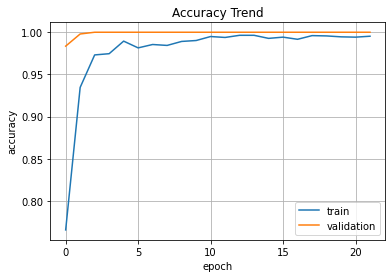

In [31]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

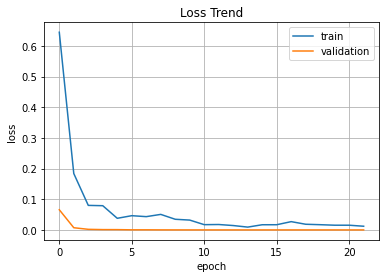

In [32]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [33]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [34]:
test_generator = test_datagen.flow_from_directory(test_dir, 
                                              batch_size=32,
                                              color_mode='rgb',
                                              class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 360 images belonging to 4 classes.


In [35]:
model.evaluate(test_generator)

12/12 [==============================] - 3s 179ms/step - loss: 3.7861e-06 - accuracy: 1.0000


[3.7861141208850313e-06, 1.0]

In [36]:
best_model.evaluate(test_generator)

12/12 [==============================] - 3s 163ms/step - loss: 7.7106e-05 - accuracy: 1.0000


[7.71057020756416e-05, 1.0]

In [43]:
import random
import os
import numpy as np
import cv2
import glob

# ['daikon', 'cabbage', 'carrot', 'garlic']
label_dict = {'cabbage': 0, 'carrot': 1, 'daikon': 2, 'garlic': 3}

test_image_files_list = glob.glob(root_dir+ '/crop_image/test_image_files/*.jpg')

random.shuffle(test_image_files_list)

# 파일형식은 정답.숫자.jpg 이므로 정답을 분리할수 있다

test_num = 16

test_image_files = test_image_files_list[:test_num]

print(test_image_files)

label_list = []

for i in range(len(test_image_files)):

    label = test_image_files[i].split('/')[-1].split('.')[0].strip()

    label_list.append(label_dict[label])

print(label_list)

# 이미지 파일 읽어옴

src_img_list = []

for i in range(len(test_image_files)):

    src_img = cv2.imread(test_image_files[i], cv2.IMREAD_COLOR)

    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    src_img = src_img / 255.0

    src_img_list.append(src_img)

# 4차원 텐서  변환

src_img_array = np.array(src_img_list)
label_array = np.array(label_list)

print(src_img_array.shape, label_array.shape)

print(label_array)

['/content/crop_image/test_image_files/garlic.304.jpg', '/content/crop_image/test_image_files/garlic.443.jpg', '/content/crop_image/test_image_files/daikon.503.jpg', '/content/crop_image/test_image_files/daikon.230.jpg', '/content/crop_image/test_image_files/cabbage.713.jpg', '/content/crop_image/test_image_files/cabbage.71.jpg', '/content/crop_image/test_image_files/cabbage.131.jpg', '/content/crop_image/test_image_files/daikon.572.jpg', '/content/crop_image/test_image_files/garlic.290.jpg', '/content/crop_image/test_image_files/garlic.1.jpg', '/content/crop_image/test_image_files/cabbage.339.jpg', '/content/crop_image/test_image_files/carrot.3.jpg', '/content/crop_image/test_image_files/daikon.298.jpg', '/content/crop_image/test_image_files/daikon.884.jpg', '/content/crop_image/test_image_files/garlic.579.jpg', '/content/crop_image/test_image_files/daikon.431.jpg']
[3, 3, 2, 2, 0, 0, 0, 2, 3, 3, 0, 1, 2, 2, 3, 2]
(16, 224, 224, 3) (16,)
[3 3 2 2 0 0 0 2 3 3 0 1 2 2 3 2]


In [44]:
best_pred = best_model.predict(src_img_array)

pred = model.predict(src_img_array)

print(best_pred.shape, pred.shape)

(16, 4) (16, 4)


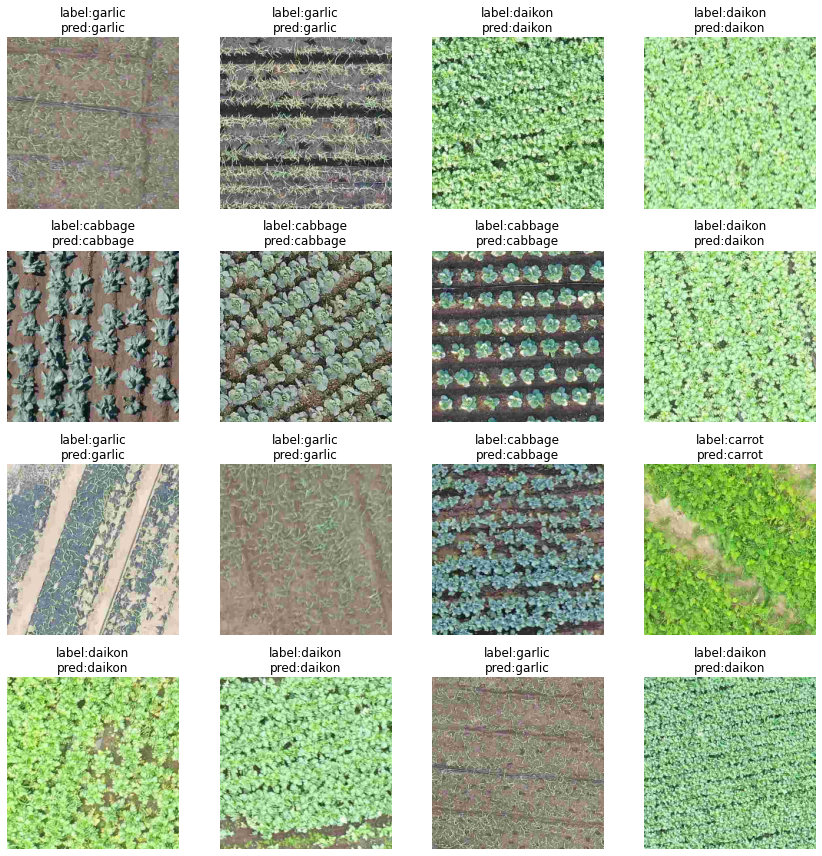

In [46]:
import matplotlib.pyplot as plt

# label_dict = {'cabbage': 0, 'carrot': 1, 'daikon': 2, 'garlic': 3}
class_names = ['cabbage', 'carrot', 'daikon', 'garlic']

plt.figure(figsize=(12,12))

for pos in range(len(best_pred)):

    plt.subplot(4,4,pos+1)
    plt.axis('off')

    label_str = class_names[label_array[pos]]
    pred_str = class_names[np.argmax(best_pred[pos])]

    plt.title('label:' + label_str + '\npred:' + pred_str)

    plt.imshow(src_img_array[pos])

plt.tight_layout()
plt.show()

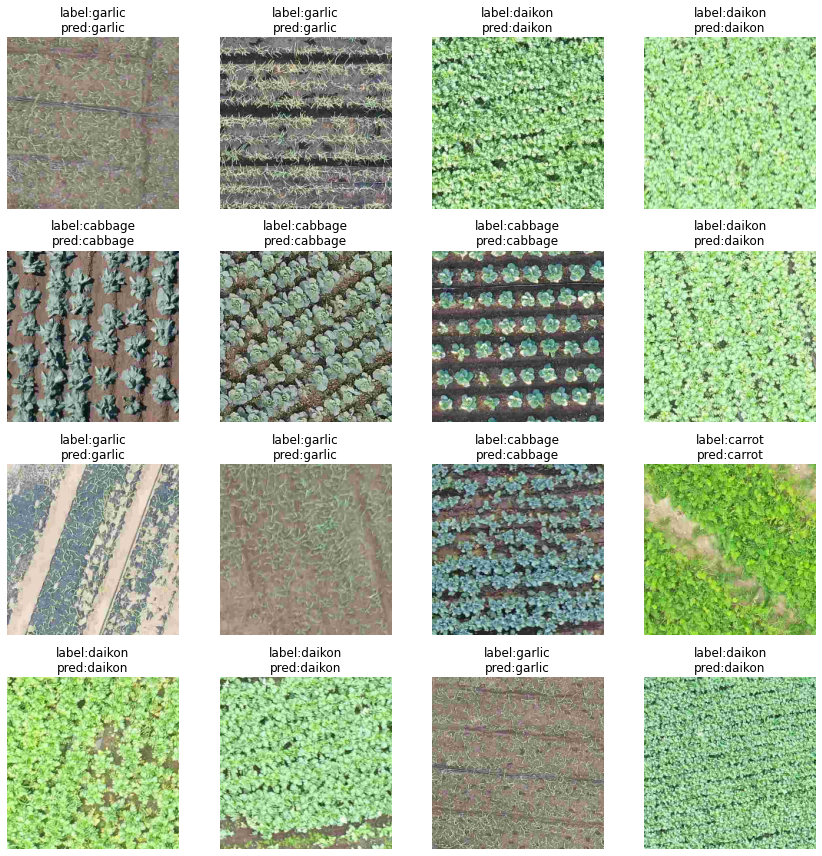

In [47]:
import matplotlib.pyplot as plt

# label_dict = {'cabbage': 0, 'carrot': 1, 'daikon': 2, 'garlic': 3}
class_names = ['cabbage', 'carrot', 'daikon', 'garlic']

plt.figure(figsize=(12,12))

for pos in range(len(pred)):

    plt.subplot(4,4,pos+1)
    plt.axis('off')

    label_str = class_names[label_array[pos]]
    pred_str = class_names[np.argmax(pred[pos])]

    plt.title('label:' + label_str + '\npred:' + pred_str)

    plt.imshow(src_img_array[pos])

plt.tight_layout()
plt.show()